# MLRS2 - Exercise GAN - _SOLUTION_

Please follow this notebook and fill missing parts based no the description in the README.md.

In [ ]:
# Install dependencies (only when using Google Colab)
!pip install torch torchvision matplotlib tensorboard torchsummary array2gif jupyter tqdm

In [1]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchsummary import summary
from array2gif import write_gif

%load_ext tensorboard

In [2]:
def show_image_batch(batch, name=""):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"{name} images")
    plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Function to convert a tensor to an image plot
def tensor_to_plot_image(tensor):
    tensor = tensor.cpu().numpy()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(tensor)
    
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    image = Image.open(buf)
    image = np.array(image)
    return image

In [3]:
n_epochs = 100
batch_size = 64
learning_rate = 0.0002
momentum = 0.5
z_dim = 100
image_size = (28, 28)
n_conv = 64
real_label = 1
fake_label = 0

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs("./ckpts", exist_ok=True)

In [4]:
# Download MNIST dataset
mnist_dataset = MNIST('./data', train=True, download=True, transform=ToTensor())
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

### Building the Discriminator

Now, let's define the **discriminator** model. It acts as a binary classifier to distinguish real MNIST digits from the fake ones generated by the generator. Pay attention to the use of convolutional layers, `LeakyReLU`, and the final sigmoid activation.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_conv):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, n_conv, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(n_conv, n_conv * 2, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(n_conv * 2, n_conv * 4, kernel_size=(3, 3), stride=2, padding=1)

        self.conv4 = nn.Conv2d(n_conv * 4, 1, kernel_size=(4, 4), stride=1, padding=0)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = self.conv4(x)

        x = x.squeeze(-1).squeeze(-1)
        
        return torch.sigmoid(x)

    def save_checkpoint(self, optimizer, filepath):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, filepath)
        #print(f"Discriminator checkpoint saved to {filepath}")        

    def load_checkpoint(self, optimizer, filepath):
        checkpoint = torch.load(filepath)
        self.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        #print(f"Discriminator checkpoint loaded from {filepath}")


        

### Building the Generator

Next, we'll design the **generator** model. This model transforms a latent vector (sampled from a Gaussian distribution) into a 28×28 grayscale image. We'll use transposed convolutions to upscale the feature maps.

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, n_conv):
        super(Generator, self).__init__()

        self.n_conv = n_conv
        self.fc = nn.Linear(z_dim, 4*4*4*n_conv)

        self.upconv1 = nn.ConvTranspose2d(n_conv * 4, n_conv * 2, kernel_size=(3, 3), stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(n_conv * 2, n_conv, kernel_size=(4, 4), stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(n_conv, 1, kernel_size=(4, 4), stride=2, padding=1)
        

    def forward(self, x):
        out = self.fc(x)

        out = out.view(-1, self.n_conv*4, 4, 4) # (batch_size, depth, 4, 4)

        x = F.leaky_relu(self.upconv1(out), 0.2)
        x = F.leaky_relu(self.upconv2(x), 0.2)        
        x = F.leaky_relu(self.upconv3(x), 0.2)
        
        return torch.sigmoid(x)
    
    def save_checkpoint(self, optimizer, filepath):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, filepath)
        
        #print(f"Generator checkpoint saved to {filepath}")        

    def load_checkpoint(self, optimizer, filepath):
        checkpoint = torch.load(filepath)
        self.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        #print(f"Generator checkpoint loaded from {filepath}")

In [7]:
# Initialize D and G
D = Discriminator(n_conv=n_conv).to(device)
G = Generator(z_dim=z_dim, n_conv=n_conv).to(device)

summary(D, input_size=(1, 28, 28))
summary(G, input_size=(1, 100))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
            Conv2d-2            [-1, 128, 7, 7]          73,856
            Conv2d-3            [-1, 256, 4, 4]         295,168
            Conv2d-4              [-1, 1, 1, 1]           4,097
Total params: 373,761
Trainable params: 373,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 1.43
Estimated Total Size (MB): 1.60
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]         413,696
   ConvTranspose2d-2            [-1, 128, 7, 7]         295,040
   ConvTranspose2d-3           [-1, 64, 1

In [8]:
# Prepare some data samples and create fake images
x_real = next(iter(train_loader))[0]
z_noise = torch.randn(batch_size, z_dim, device=device)

Dout = D(x_real.to(device))
x_fake = G(z_noise)

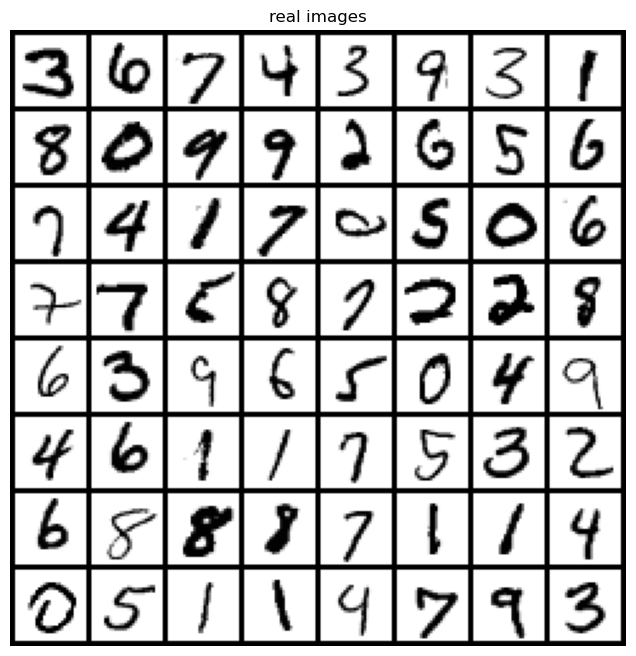

In [9]:
# Show real images
show_image_batch((1 - x_real), name="real")

In [10]:
# Transform 1D plots to images
plot_images = np.array([tensor_to_plot_image(z_noise[i]) for i in range(len(z_noise))])
plot_images = torch.tensor(plot_images, dtype=torch.float32)[..., :-1]
plot_images /= 255.
plot_images = torch.permute(plot_images, (0, 3, 1, 2))

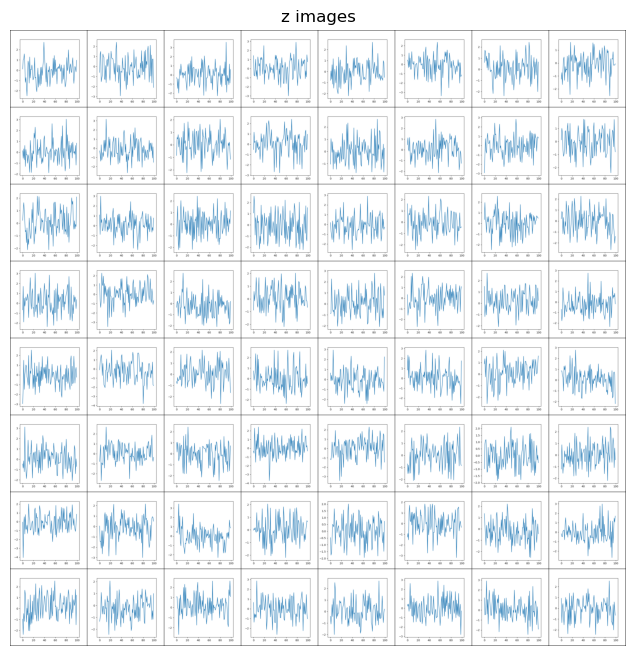

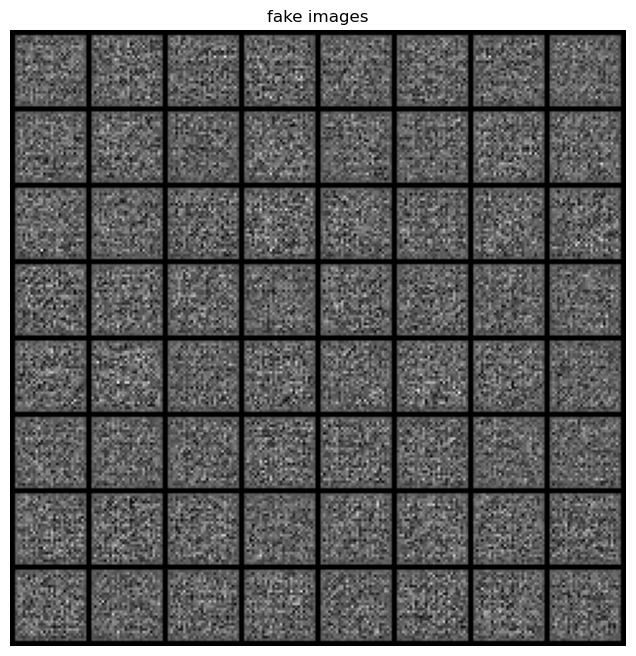

In [11]:
# Show latent vector and corresponding generated fake image from the generator
show_image_batch(plot_images, name="z")
show_image_batch(x_fake, name="fake")

In [12]:
%reload_ext tensorboard
%tensorboard --logdir ./runs

In [13]:
# Setup Loss and Adam optimizers for both G and D
loss_fn = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=learning_rate, betas=(momentum, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=learning_rate, betas=(momentum, 0.999))

In [14]:
writer = SummaryWriter()
img_list = []
total_iters = 0

### Adversarial Training Loop

Time to bring both networks together! Implement the mini-max training loop where the discriminator and generator train in an adversarial fashion. Follow the three-step process: 
1. Train discriminator on real data
2. Train discriminator on fake data
3. Train generator to fool the discriminator

Make sure to monitor losses for both networks during training.

In [18]:
start_time = time.time()
for epoch in range(n_epochs):
    loop = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)
    for i, data in loop:
        # (1) Update the discriminator with real data
        D.zero_grad()
        # Format batch
        x_real = data[0].to(device)
        label = torch.full((x_real.size(0), 1), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(x_real)
        # Calculate loss on all-real batch
        loss_real = loss_fn(output, label)
        # Calculate gradients for D in backward pass
        loss_real.backward(retain_graph=True)
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, z_dim, device=device)
        # Generate fake image batch with G
        x_fake = G(noise)
        # Classify all fake batch with D
        output = D(x_fake.detach())
        # Calculate D's loss on the all-fake batch
        label = torch.full((output.size(0), 1), fake_label, dtype=torch.float, device=device)
        loss_fake = loss_fn(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        loss_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        loss_D = loss_real + loss_fake
        loss_D.backward(retain_graph=True)
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        G.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(x_fake)
         # fake labels are real for generator cost
        label = torch.full((output.size(0), 1), real_label, dtype=torch.float, device=device) 
        # Calculate G's loss based on this output
        loss_G = loss_fn(output, label[:output.shape[0]])
        # Calculate gradients for G
        loss_G.backward()
        # Update G
        optimizerG.step()

        D_G_z2 = output.mean().item()

        
        # Output training stats
        if i % 50 == 0:
            
            writer.add_scalar("Losses/G_loss", loss_G.item(), total_iters)
            writer.add_scalar("Losses/D_loss", loss_D.item(), total_iters)

        loop.set_postfix({
            'Loss_D': f'{loss_D.item():.4f}',
            'Loss_G': f'{loss_G.item():.4f}',
            'D(x)': f'{D_x:.4f}',
            'D(G(z))': f'{D_G_z1:.4f}/{D_G_z2:.4f}'
        })
        # Check how the generator is doing by saving G's output on fixed_noise
        if (total_iters % 50 == 0) or ((epoch == n_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                x_fake = G(z_noise).detach().cpu()
            img_list.append(vutils.make_grid(x_fake, padding=2, normalize=True))
        
        total_iters += 1
    D.save_checkpoint(optimizerD, "./ckpts/discriminator.ckpt")
    G.save_checkpoint(optimizerG, "./ckpts/generator.ckpt")
elapsed_time = time.time() - start_time
print("Training time (sec): ", elapsed_time)

Epoch 1/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/938 [00:00<?, ?it/s]

Training time (sec):  501.0497679710388


In [19]:
D.load_checkpoint(optimizerD, "./ckpts/discriminator.ckpt")
G.load_checkpoint(optimizerG, "./ckpts/generator.ckpt")

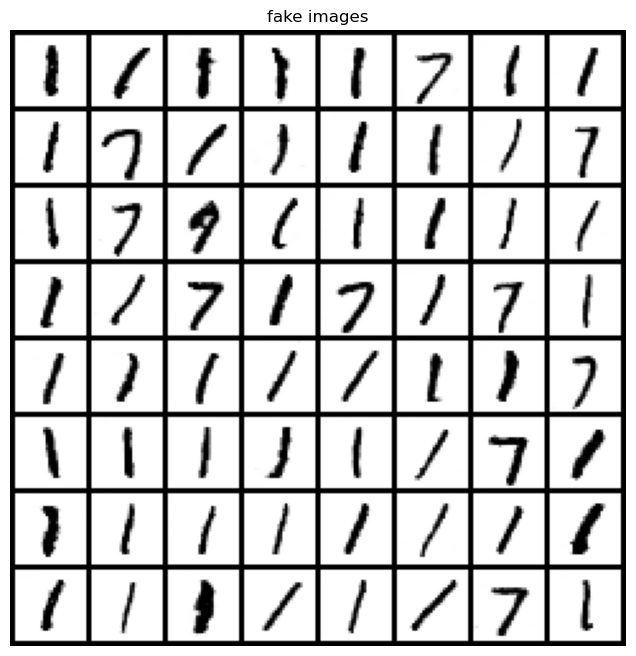

In [20]:
with torch.no_grad():
    x_fake = G(z_noise).detach().cpu()

show_image_batch((1. - x_fake), name="fake")

In [21]:
# Generate and safe GIF from generated images from G
img_list_arr = np.array(img_list)
img_list_arr = (1. - img_list_arr)
img_list_arr *= 255
img_list_arr = img_list_arr.astype(np.uint8)

write_gif(img_list_arr, 'imgs_G.gif', fps=50)

## Summary

Great job completing the exercise notebook! The resulting GIF shows how the generator learns over time how to generate number images: [imgs_G.gif](imgs_G.gif)